In [1]:
import json

with open("rag_truth_train2.json", "r") as f:
    train_data = json.load(f)
with open("rag_truth_dev.json", "r") as f:
    dev_data = json.load(f)
with open("rag_truth_test.json", "r") as f:
    test_data = json.load(f)

In [2]:
# prefixをつける
def add_prefix(data):
    for d in data:
        d["text"] = "Please judge the following statement as true or false based on the references above: " + d["text"]
    return data

train_data = add_prefix(train_data)
dev_data = add_prefix(dev_data)
test_data = add_prefix(test_data)

In [31]:
# task_type: QA, Data2txt, Summary
task_name = "Summary"
train_data = [d for d in train_data if d["task_type"] == task_name]
dev_data = [d for d in dev_data if d["task_type"] == task_name]
test_data = [d for d in test_data if d["task_type"] == task_name]

In [3]:
from datasets import Dataset, DatasetDict
import pandas as pd

train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)
train_ds = Dataset.from_pandas(train_df)
dev_ds = Dataset.from_pandas(dev_df)
test_ds = Dataset.from_pandas(test_df)

raw_datasets = DatasetDict({"train": train_ds, "dev":dev_ds, "test": test_ds})
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 13830
    })
    dev: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['ref', 'text', 'labels', 'source', 'model', 'task_type', 'source_id'],
        num_rows: 2700
    })
})

In [28]:
from transformers import AutoTokenizer, DataCollatorWithPadding


tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
#tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large",use_fast=False)

def tokenize_function(examples):
    ref = tokenizer(examples["ref"],truncation=True, max_length=512,padding="max_length")
    text = tokenizer(examples["text"],truncation=True, max_length=512,padding="max_length")
    return {
        "ref_input_ids":ref["input_ids"],
        "ref_attention_mask":ref["attention_mask"],
        "text_input_ids":text["input_ids"],
        "text_attention_mask":text["attention_mask"],
    }

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text","ref"])
#tokenized_datasets.set_format("torch")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/13830 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/2700 [00:00<?, ? examples/s]

In [29]:
from transformers import DataCollatorWithPadding
from torch.nn.utils.rnn import pad_sequence
import torch

class CustomDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # features の例: [{'anchor_input_ids': ..., 'anchor_attention_mask': ..., ...}, ...]
        
        # データのリストを作成
        ref_ids = [torch.tensor(x['ref_input_ids']) for x in features]
        text_ids = [torch.tensor(x['text_input_ids']) for x in features]
       
        
        ref_mask = [torch.tensor(x['ref_attention_mask']) for x in features]
        text_mask = [torch.tensor(x['text_attention_mask']) for x in features]
        labels = torch.tensor([x['labels'] for x in features])
        
        # パディング処理
        ref_ids = pad_sequence(ref_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        text_ids = pad_sequence(text_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        
        ref_mask = pad_sequence(ref_mask, batch_first=True, padding_value=0)
        text_mask = pad_sequence(text_mask, batch_first=True, padding_value=0)
        
        # バッチ辞書を作成
        batch = {
            "input_ids": [ref_ids, text_ids],
            "attention_mask": [ref_mask, text_mask],
            "labels": labels
        }
        
        return batch


data_collator = CustomDataCollator(tokenizer=tokenizer)

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'source', 'model', 'task_type', 'source_id', 'ref_input_ids', 'ref_attention_mask', 'text_input_ids', 'text_attention_mask'],
        num_rows: 13830
    })
    dev: Dataset({
        features: ['labels', 'source', 'model', 'task_type', 'source_id', 'ref_input_ids', 'ref_attention_mask', 'text_input_ids', 'text_attention_mask'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['labels', 'source', 'model', 'task_type', 'source_id', 'ref_input_ids', 'ref_attention_mask', 'text_input_ids', 'text_attention_mask'],
        num_rows: 2700
    })
})

In [31]:
from transformers import AutoModel

#tri_model = AutoModelForSequenceClassification.from_pretrained("FacebookAI/RoBERTa-base", num_labels=2)
base_model = AutoModel.from_pretrained("FacebookAI/RoBERTa-base")
#base_model = AutoModel.from_pretrained("vinai/bertweet-large")

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/RoBERTa-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
import torch

# 使う装置
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
base_model.to(device)
device

device(type='cuda')

In [49]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import ModelOutput

loss_list = []
class RagModel(nn.Module):
    def __init__(self, base_model, question_encoder=None, generator=None):
        super(RagModel, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.1) 
        self.classifier = nn.Linear(base_model.config.hidden_size*2, 2)  # ラベル予測用の分類層
        self.question_encoder = question_encoder
        self.generator = generator

    def forward(
        self,
        input_ids,
        attention_mask = None,
        labels = None

    ):
        
        ref_input_ids = input_ids[0]
        text_input_ids = input_ids[1]
        ref_attention_mask = attention_mask[0]
        text_attention_mask = attention_mask[1]
        #print(ref_input_ids.shape,ref_attention_mask.shape, text_input_ids.shape, text_attention_mask.shape)

        
        ref_output = self.base_model(input_ids=ref_input_ids, attention_mask=ref_attention_mask)[0][:,0,:]#[1]
        text_output = self.base_model(input_ids=text_input_ids, attention_mask=text_attention_mask)[0][:,0,:]#[1]
        #output = self.base_model(input_ids=torch.cat([ref_input_ids, text_input_ids], dim=1), attention_mask=torch.cat([ref_attention_mask, text_attention_mask], dim=1))[1]
      
        ref_output = self.dropout(ref_output)
        text_output = self.dropout(text_output)
        #output = self.dropout(output)

        # ラベル予測の出力
        logits = self.classifier(torch.cat([ref_output, text_output], dim=1))
        #logits = self.classifier(output)
        
        loss = nn.CrossEntropyLoss()(logits, labels) if labels is not None else None
        loss_list.append(loss)

        return ModelOutput(logits=logits, loss=loss)
        #return ModelOutput(loss=loss)
        
    def save_pretrained(self, save_directory):
        """
        モデル全体とサブモジュールを保存するカスタムメソッド
        """
        os.makedirs(save_directory, exist_ok=True)

        # サブモジュールの保存
        if self.question_encoder is not None:
            self.question_encoder.save_pretrained(os.path.join(save_directory, "question_encoder"))
        if self.generator is not None:
            self.generator.save_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みを保存
        torch.save(self.state_dict(), os.path.join(save_directory, "pytorch_model.bin"))

    @classmethod
    def from_pretrained(cls, save_directory):
        """
        保存済みモデルをロードするカスタムメソッド
        """
        question_encoder = None
        generator = None

        # サブモジュールのロード
        if os.path.exists(os.path.join(save_directory, "question_encoder")):
            question_encoder = AutoModel.from_pretrained(os.path.join(save_directory, "question_encoder"))
        if os.path.exists(os.path.join(save_directory, "generator")):
            generator = AutoModel.from_pretrained(os.path.join(save_directory, "generator"))

        # モデル全体の重みをロード
        model = cls(question_encoder=question_encoder, generator=generator)
        model.load_state_dict(torch.load(os.path.join(save_directory, "pytorch_model.bin")))

        return model

In [50]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1).tolist()  # ndarray をリストに変換
    labels = labels.tolist()  # ndarray をリストに変換
    
    # accuracy と f1 score を計算
    accuracy = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions)
    precision = precision_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

In [51]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification
import torch
from torch.nn.parallel import DataParallel
import os

#training_args = TrainingArguments("test-trainer")
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="steps",  
    save_steps=10000,
    learning_rate=5e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16 = True,
    gradient_accumulation_steps=12,
    logging_dir="./logs",
    remove_unused_columns=False,
    report_to="tensorboard",
)

#model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=4)
model = RagModel(base_model)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)




/gs/fs/tga-arase-student/yamada/nlp/lib64/python3.9/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/tmp/19755.1.interactive/ipykernel_834827/3701344241.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [52]:
trainer.evaluate()

{'eval_loss': 0.7032307982444763,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.4246031746031746,
 'eval_recall': 1.0,
 'eval_precision': 0.4246031746031746,
 'eval_f1': 0.596100278551532,
 'eval_runtime': 4.4234,
 'eval_samples_per_second': 284.847,
 'eval_steps_per_second': 71.212}

In [53]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Recall,Precision,F1
0,0.610000,0.575513,0.002900,0.723016,0.667290,0.676136,0.671684
1,0.533200,0.523739,0.002900,0.740476,0.659813,0.708835,0.683446
2,0.507500,0.506865,0.002900,0.748413,0.680374,0.713725,0.696651
3,0.487500,0.504371,0.002900,0.740476,0.723364,0.683746,0.702997
4,0.466800,0.491205,0.002900,0.768254,0.699065,0.740594,0.719231
6,0.434600,0.559652,0.002900,0.709524,0.768224,0.629403,0.691919
7,0.418500,0.509208,0.002900,0.754762,0.727103,0.704710,0.715731
8,0.405800,0.568975,0.002900,0.710317,0.790654,0.625740,0.698596
9,0.396600,0.562833,0.002900,0.712698,0.785047,0.629685,0.698835


TrainOutput(global_step=2880, training_loss=0.4709526300430298, metrics={'train_runtime': 1608.1224, 'train_samples_per_second': 86.001, 'train_steps_per_second': 1.791, 'total_flos': 0.0, 'train_loss': 0.4709526300430298, 'epoch': 9.994216310005784})

In [60]:
trainer.evaluate(eval_dataset=tokenized_datasets["test"])

{'eval_loss': 0.5867388844490051,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.7218518518518519,
 'eval_recall': 0.792152704135737,
 'eval_precision': 0.5737327188940092,
 'eval_f1': 0.6654788418708241,
 'eval_runtime': 9.9957,
 'eval_samples_per_second': 270.117,
 'eval_steps_per_second': 67.529,
 'epoch': 9.994216310005784}

In [58]:
# トレーニング後にモデルを保存
import os

name = "./0102_rag_rob"
trainer.save_model(name)
trainer.save_state()
model.save_pretrained(name)

In [54]:
def create_dev_task(name):
    dev_data2 = [d for d in test_data if d["task_type"] == name]
    dev_df2 = pd.DataFrame(dev_data2)
    dev_ds2 = Dataset.from_pandas(dev_df2)
    tokenized_datasets_task = dev_ds2.map(tokenize_function, batched=True)
    tokenized_datasets_task = tokenized_datasets_task.remove_columns(["text","ref"])
    return tokenized_datasets_task

In [55]:
dev_qa = create_dev_task("QA")
trainer.evaluate(eval_dataset=dev_qa)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.5746981501579285,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.6988888888888889,
 'eval_recall': 0.725,
 'eval_precision': 0.33819241982507287,
 'eval_f1': 0.46123260437375746,
 'eval_runtime': 3.1617,
 'eval_samples_per_second': 284.657,
 'eval_steps_per_second': 71.164,
 'epoch': 9.994216310005784}

In [56]:
dev_d2t = create_dev_task("Data2txt")
trainer.evaluate(eval_dataset=dev_d2t)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.584356427192688,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.7788888888888889,
 'eval_recall': 0.9430051813471503,
 'eval_precision': 0.7668539325842697,
 'eval_f1': 0.8458559256390396,
 'eval_runtime': 3.3586,
 'eval_samples_per_second': 267.967,
 'eval_steps_per_second': 66.992,
 'epoch': 9.994216310005784}

In [57]:
dev_sum = create_dev_task("Summary")
trainer.evaluate(eval_dataset=dev_sum)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

{'eval_loss': 0.6011621356010437,
 'eval_model_preparation_time': 0.0029,
 'eval_accuracy': 0.6877777777777778,
 'eval_recall': 0.4166666666666667,
 'eval_precision': 0.3441295546558704,
 'eval_f1': 0.376940133037694,
 'eval_runtime': 3.3422,
 'eval_samples_per_second': 269.283,
 'eval_steps_per_second': 67.321,
 'epoch': 9.994216310005784}

In [58]:
loss_list = [x.item() for x in loss_list]

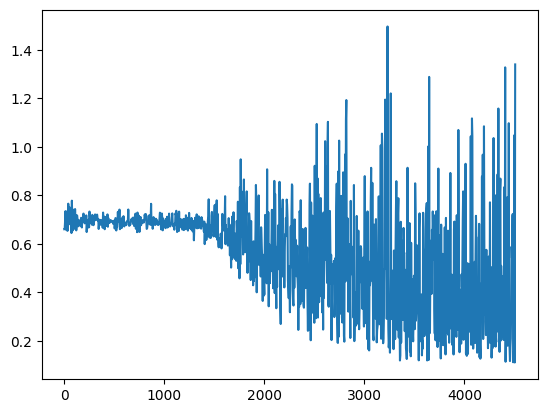

In [19]:
import matplotlib.pyplot as plt

x = np.arange(0,len(loss_list),len(loss_list)//1000)
loss_list = np.array(loss_list)
plt.plot(x,loss_list[x])
plt.show()

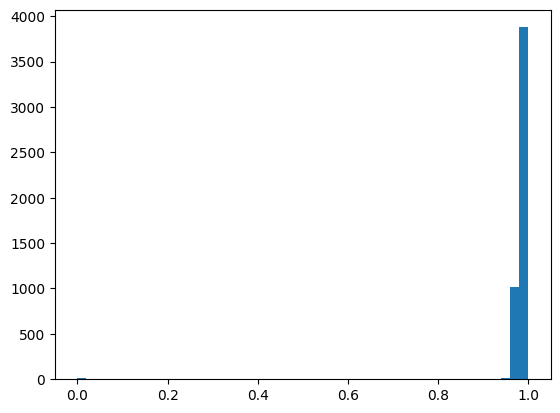

In [11]:
import matplotlib.pyplot as plt
plt.hist(sim_max_list,bins = 50)
plt.show()

In [13]:
a = sorted(sim_max_list)
print(a)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.90464556, 0.9212556, 0.93984485, 0.94295806, 0.9513694, 0.951383, 0.9539271, 0.95531106, 0.95738953, 0.9575629, 0.957964, 0.9582137, 0.9584233, 0.95923865, 0.9593846, 0.95967674, 0.95971745, 0.9606648, 0.9608012, 0.96096396, 0.96225053, 0.96276176, 0.96276176, 0.96294945, 0.9632443, 0.96407986, 0.9643437, 0.96449286, 0.9645673, 0.964732, 0.9650366, 0.9651434, 0.96518755, 0.9653988, 0.9653988, 0.9658783, 0.9658849, 0.9659888, 0.96601033, 0.96611047, 0.96623546, 0.96625733, 0.966701, 0.96685135, 0.9668739, 0.9669263, 0.9669808, 0.9669827, 0.9671059, 0.96715724, 0.9672449, 0.96745414, 0.96756184, 0.9677217, 0.9677791, 0.96795815, 0.9679923, 0.9681783, 0.96818423, 0.9682004, 0.96824217, 0.9682447, 0.96834266, 0.9683701, 0.96846116, 0.9685011, 0.96853346, 0.96856993, 0.968593, 0.9686514, 0.9687822, 0.9688374, 0.9688515, 0.9688517, 0.9688868, 0.9689391, 0.9689461, 0.9690015, 0.96909684, 0.9691247, 0.96912956, 0.96917695, 0.96925396, 0.9692985, 0.96932054, 0.9